In [1]:
# A check to see if environment variables are setup correctly:
import sys, math, random, ROOT, uproot, torch
import numpy as np

Welcome to JupyROOT 6.16/00


In [2]:
# now do stuff:
signal_file = ROOT.TFile("formatted/tau_signal.root")
signal_tree = signal_file.Get("signal")

background_file = ROOT.TFile("formatted/background.root")
background_tree = background_file.Get("background")

signal_entries = signal_tree.GetEntries()
background_entries = background_tree.GetEntries()
print(signal_entries)
print(background_entries)
#signal_tree.Print()

7812
69049


In [3]:
signal_layer_ets = []
background_layer_ets = []
all_layer_ets = []
all_truth = []

for i in range(signal_entries):
    signal_tree.GetEntry(i)
    layer_ets = [signal_tree.L0EM, signal_tree.L1EM, signal_tree.L2EM, signal_tree.L3EM, signal_tree.LHAD]
    layer_ets = [et / 1000. for et in layer_ets]
    
    signal_layer_ets.append(layer_ets)
    all_layer_ets.append(layer_ets)
    
    all_truth.append(1)
    
    
for i in range(background_entries):
    background_tree.GetEntry(i)
    layer_ets = [background_tree.L0EM, background_tree.L1EM, background_tree.L2EM, background_tree.L3EM, background_tree.LHAD]
    layer_ets = [et / 1000. for et in layer_ets]
    
    background_layer_ets.append(layer_ets)
    all_layer_ets.append(layer_ets)
    
    all_truth.append(0)

In [4]:
# Create a histogram of reconstructed Et of all signal and background events
h_signal = ROOT.TH1F("signal_recoEt", "signal_recoEt", 100, -20, 100)
h_signal.GetXaxis().SetTitle("Reconstructed Et")
h_signal.GetYaxis().SetTitle("Events")

h_background = ROOT.TH1F("background_recoEt", "background_recoEt", 100, -20, 100)
h_background.GetXaxis().SetTitle("Reconstructed Et")
h_background.GetYaxis().SetTitle("Events")

c = ROOT.TCanvas("c", "canvas", 400, 400)

In [5]:
h_signal.Reset()
for event in signal_layer_ets:
    h_signal.Fill(sum(event))
print(h_signal.GetEntries())
    
h_background.Reset()
for event in background_layer_ets:
    h_background.Fill(sum(event))
print(h_background.GetEntries())

7812.0
69049.0


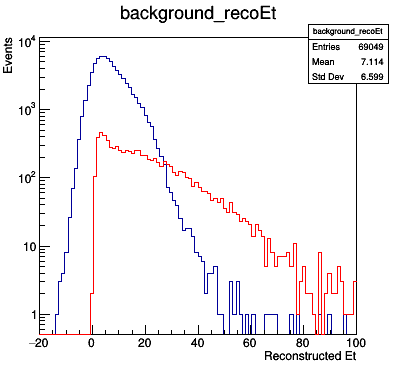

In [6]:
h_background.Draw()
h_signal.Draw('same')
h_signal.SetLineColor(2)
c.SetLogy()
c.Draw()

In [7]:
# Create data for initial ROC curves
signal_roc_counts = np.zeros(100)
background_roc_counts = np.zeros(100)

signal_roc_counts[0] += 1

for i, layers in enumerate(all_layer_ets):
    total_et = sum(layers)
    
    for j in range(100):
        if total_et > j:
            if all_truth[i] == 1:
                signal_roc_counts[j] += 1
            elif all_truth[i] == 0:
                background_roc_counts[j] += 1
            
# Convert event counts to efficiencies
signal_roc_eff = np.array([float(sig_count / signal_roc_counts[0]) for sig_count in signal_roc_counts])
background_roc_eff = np.array([float(back_count / background_roc_counts[0]) for back_count in background_roc_counts])

#signal_roc_eff = list(signal_roc_eff)
#background_roc_eff = list(background_roc_eff)

#print(signal_roc_counts)
#print(signal_roc_eff)
#print(background_roc_counts)
#print(background_roc_eff)

In [8]:
# separate data into training and testing sets: 
nTotalEvents = len(all_layer_ets)
nTrainingEvents = 0
nTestingEvents = 0

test_all_layer_ets = []
train_all_layer_ets = []
test_all_truth = []
train_all_truth = []

index_shuf = list(range(nTotalEvents))
random.shuffle(index_shuf)
for i in index_shuf:
    if i % 2 == 0:
        test_all_layer_ets.append(all_layer_ets[i])
        test_all_truth.append(all_truth[i])
        nTestingEvents += 1
    else:
        train_all_layer_ets.append(all_layer_ets[i])
        train_all_truth.append(all_truth[i])
        nTrainingEvents += 1

print(" total nEvents: {0}\n training nEvents: {1}\n testing nEvents: {2}\n".format(nTotalEvents,nTrainingEvents,nTestingEvents))        
        
# cast all_data list to numpy array:
npArray_all_layer_ets = np.array(all_layer_ets)
npArray_test_all_layer_ets = np.array(test_all_layer_ets)
npArray_train_all_layer_ets = np.array(train_all_layer_ets)

# NN input vectors:
X_train = torch.from_numpy(np.dstack([
    npArray_train_all_layer_ets[:,0], 
    npArray_train_all_layer_ets[:,1], 
    npArray_train_all_layer_ets[:,2], 
    npArray_train_all_layer_ets[:,3],
    npArray_train_all_layer_ets[:,4]])[0].astype(np.float32)) 

X_test = torch.from_numpy(np.dstack([
    npArray_test_all_layer_ets[:,0], 
    npArray_test_all_layer_ets[:,1], 
    npArray_test_all_layer_ets[:,2], 
    npArray_test_all_layer_ets[:,3],
    npArray_test_all_layer_ets[:,4]])[0].astype(np.float32))

# NN test value: 0=background, 1=signal
Y_test = torch.from_numpy(np.array(test_all_truth).astype(np.float32).reshape(-1, 1))
Y_train = torch.from_numpy(np.array(train_all_truth).astype(np.float32).reshape(-1, 1))

# NN parameters:
neural_network = torch.nn.Sequential(    # the neural network topology:
    torch.nn.Linear(5, 8),               # input → hidden: 5 dimensions → 8 dimensions
    torch.nn.Sigmoid(),
    torch.nn.Linear(8, 8),               # non-linearity applied to each of the 5 components
    torch.nn.Sigmoid(),
    torch.nn.Linear(8, 1))               # hidden → output: 5 dimensions → 1 dimension

loss_fn = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(neural_network.parameters(), lr=0.075)

# train the network:
for i in range(5000):                    # iterate 100 times to minimize loss: y_pred - y
    y_pred = neural_network(X_train)           # neural_network is a function: X ↦ y
    loss = loss_fn(y_pred, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 1000 == 1:
        print(loss.item())
        

 total nEvents: 76861
 training nEvents: 38430
 testing nEvents: 38431

4264.73388671875
1954.1448974609375
1515.259033203125
1389.8133544921875
1317.889892578125


Info in <TCanvas::Print>: pdf file nn_weights.pdf has been created


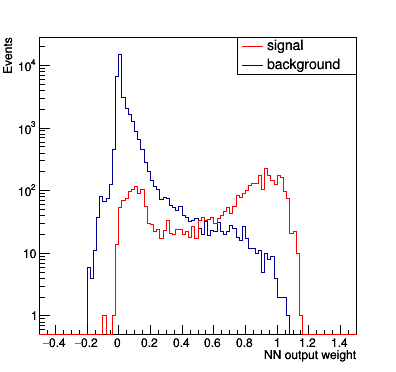

In [9]:
# check the NN output for event 0:    
h_nnOutputWeights_sig = ROOT.TH1F("nn_sig", "nn_sig", 100, -0.5, 1.5)
h_nnOutputWeights_sig.SetLineColor(ROOT.kRed)
h_nnOutputWeights_bkg = ROOT.TH1F("nn_bkg", "nn_bkg", 100, -0.5, 1.5)
h_nnOutputWeights_sig.GetXaxis().SetTitle("NN output weight")
h_nnOutputWeights_sig.GetYaxis().SetTitle("Events")
h_nnOutputWeights_bkg.GetXaxis().SetTitle("NN output weight")
h_nnOutputWeights_bkg.GetYaxis().SetTitle("Events")
h_nnOutputWeights_bkg.SetTitle("")
h_nnOutputWeights_sig.SetTitle("")

nn_leg = ROOT.TLegend(0.6, 0.8, 0.9, 0.9)
nn_leg.SetTextSize(0.04)
nn_leg.AddEntry(h_nnOutputWeights_sig, "signal","l")
nn_leg.AddEntry(h_nnOutputWeights_bkg, "background","l")

for i in range(len(X_test)):
    if Y_test[i] == 1.0:
        h_nnOutputWeights_sig.Fill(neural_network(X_test[i]))
    else:
        h_nnOutputWeights_bkg.Fill(neural_network(X_test[i]))

c_nn = ROOT.TCanvas("c_nn", "c_nn", 400, 400)
ROOT.gStyle.SetOptStat(0)
h_nnOutputWeights_bkg.Draw()
h_nnOutputWeights_sig.Draw("same")

nn_leg.Draw("same")
c_nn.SetLogy()
c_nn.Draw()

c_nn.SaveAs("nn_weights.pdf")

In [14]:
# Create data for network-trained ROC curves

# Run all testing samples through the trained network
network_outputs = neural_network(X_test)

# Create arrays to hold the number of events left after each Et cut
signal_network_roc_counts = np.zeros(100)
background_network_roc_counts = np.zeros(100)

for i, value in enumerate(network_outputs):
    #total_et = sum(layers)
    if i == 0:
        print(value)
    
    for j in range(100):
        if value > (-0.2 + j*0.01):
            if test_all_truth[i] == 1:
                signal_network_roc_counts[j] += 1
            elif test_all_truth[i] == 0:
                background_network_roc_counts[j] += 1
            
# Convert event counts to efficiencies
signal_network_roc_eff = np.array([float(sig_count / signal_network_roc_counts[0]) for sig_count in signal_network_roc_counts])
background_network_roc_eff = np.array([float(back_count / background_network_roc_counts[0]) for back_count in background_network_roc_counts])

tensor([0.0003], grad_fn=<SelectBackward>)


In [15]:
# Read in BDT efficiency arrays from flat files
#signal_bdt_efficiencies = []
with open('bdt/bdt_sigeff.txt', 'r') as sig_file:
    signal_bdt_roc_eff = sig_file.readlines()
    
with open('bdt/bdt_bkgeff.txt', 'r') as back_file:
    background_bdt_roc_eff = back_file.readlines()

signal_bdt_roc_eff = np.array([float(value) for value in signal_bdt_roc_eff])
background_bdt_roc_eff = np.array([float(value) for value in background_bdt_roc_eff])


# Cheat and add 1.0/1.0 efficiency value to BDTs to make the ROC curves look good
signal_bdt_roc_eff = np.insert(signal_bdt_roc_eff, 0, 1)
background_bdt_roc_eff = np.insert(background_bdt_roc_eff, 0, 1)

#print(signal_bdt_roc_eff)
#print(background_bdt_roc_eff)

Info in <TCanvas::Print>: pdf file roc_money_plot.pdf has been created


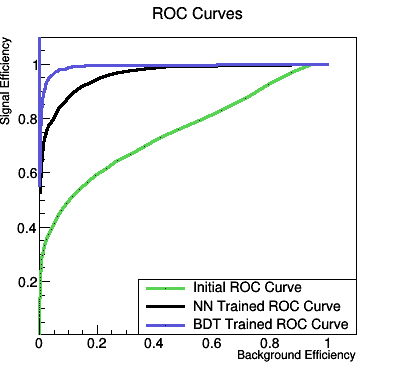

In [33]:
c.SetLogy(0)
# Plot ROC curves, should make the Y axis linear
initial_roc_curve = ROOT.TGraph(100, background_roc_eff, signal_roc_eff)
network_roc_curve = ROOT.TGraph(100, background_network_roc_eff, signal_network_roc_eff)
bdt_roc_curve = ROOT.TGraph(101, background_bdt_roc_eff, signal_bdt_roc_eff)
c.Clear()
initial_roc_curve.Draw()
initial_roc_curve.SetTitle('ROC Curves')
initial_roc_curve.SetLineColor(8)
initial_roc_curve.SetLineWidth(3)
initial_roc_curve.GetXaxis().SetTitle('Background Efficiency')
initial_roc_curve.GetYaxis().SetTitle('Signal Efficiency')
network_roc_curve.Draw('l')
network_roc_curve.SetLineColor(1)
network_roc_curve.SetLineWidth(3)

bdt_roc_curve.Draw('l')
bdt_roc_curve.SetLineColor(9)
bdt_roc_curve.SetLineWidth(3)

#ROOT.gStyle.SetLabelSize(0.04, "XY");

legend = ROOT.TLegend(.35, .1, .9, .25)
legend.SetTextSize(0.04)
legend.AddEntry(initial_roc_curve, 'Initial ROC Curve')
legend.AddEntry(network_roc_curve, 'NN Trained ROC Curve')
legend.AddEntry(bdt_roc_curve, 'BDT Trained ROC Curve')

legend.Draw()
c.Draw()
c.SaveAs("roc_money_plot.pdf")